# Graphical modeling with L-systems
In this notebook, I've coded up the L-systems that generate plants in [*The Algorithmic Beauty of Plants*](http://algorithmicbotany.org/papers/#abop). These comprise of context-free and context-sensitive production systems, as well as a graphical interpreter of produced strings.

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

# Productions

In [3]:
def gen_prods(string, prods):
    for ch in string:
        for start, result in prods:
            if start == ch:
                yield from result
                break
        else:
            yield ch

def apply_prods(string, prods, n=1):
    for _ in range(n):
        string = gen_prods(string, prods)
    return string

''.join(apply_prods('yx', [
    ('x', 'fx'),
    ('x', 'fe'),
    ('y', 'ye'),
], n=2))

'yeeffx'

# Rendering

In [4]:
def interp(string, delta=90, distance=1, throw_for_unknown_char=False):
    '''
    Interpret L-system instructions to make lines.
    '''
    delta_radians = np.pi * delta / 180

    stack = []
    # heading
    x, y = 0, distance
    pos = [0, 0]

    rot = {'-': -1, '+': +1}

    for ch in string:
        if ch == 'F':
            prev = pos
            pos = (pos[0]+x, pos[1]+y)
            yield 'L', prev, pos
        elif ch in rot:
            d = delta_radians * rot[ch]
            # https://en.wikipedia.org/wiki/Rotation_matrix
            x, y = (
                x*np.cos(d)-y*np.sin(d),
                x*np.sin(d)+y*np.cos(d),
            )
        elif ch == '[':
            stack.append((x, y, pos))
        elif ch == ']':
            x, y, pos = stack.pop()
        elif throw_for_unknown_char:
            raise ValueError('Unknown control '+ch)


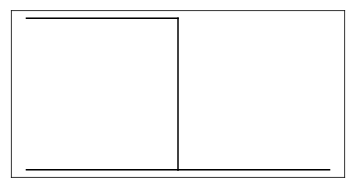

In [5]:
def render_plt(commands):
    f, ax = plt.subplots()
    ax.set(
        aspect='equal',
        xticks=[],
        yticks=[],
    )

    for c, *args in commands:
        if c == 'L':
            prev, pos = args
            ax.plot([prev[0], pos[0]], [prev[1], pos[1]], c='k')

angle_shape = '[-F][+F]F+F'
render_plt(interp(angle_shape))

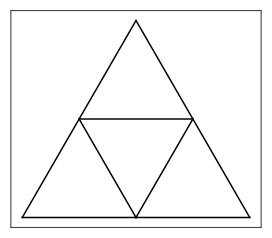

In [6]:
triforce = '-F[F----FF----FF]--F----F----F'
render_plt(interp(triforce, delta=30))

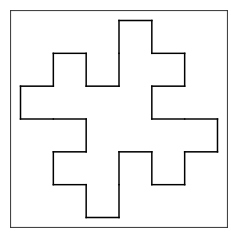

In [39]:
koch_prods = (
    ('F', 'F-F+F+FF-F-F+F'),
)
render_plt(interp(apply_prods('F-F-F-F', koch_prods, n=1)))

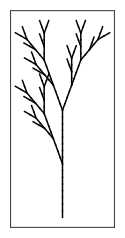

In [8]:
prods = (
    ('X', 'F[+X]F[-X]+X'),
    ('F', 'FF'),
)
render_plt(interp(apply_prods('X', prods, n=4), delta=20))

# SVG Rendering
For efficient rendering

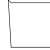

In [9]:
class SVGWrapper(object):
    def __init__(self, content, xrng=None, yrng=None, width=200, height=200):
        self.attrs = [f'width="{width}"', f'height="{height}"']
        if xrng is not None and yrng is not None:
            self.attrs.append(f'viewBox="{xrng[0]} {yrng[0]} {xrng[1]-xrng[0]} {yrng[1]-yrng[0]}"')
        self.content = content
    def _repr_svg_(self):
        return '<svg {} xmlns="http://www.w3.org/2000/svg">{}</svg>'.format(
            ' '.join(self.attrs),
            self.content)

# testing with some svg...
SVGWrapper('<path d="M 10 10 l 5 5 h 80 v 80 h -80 Z" fill="transparent" stroke="black"/>', xrng=(0, 80), yrng=(10, 100), width=50, height=50)

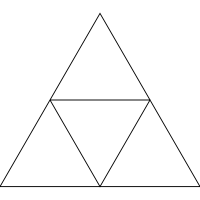

In [10]:
def render_svg(commands, **kwargs):
    svg = []
    xrng = (0, 0)
    yrng = (0, 0)
    prev_pos = None
    for c, *args in commands:
        if c == 'L':
            prev, pos = args
            if prev_pos is None or prev_pos != prev:
                svg.append('M {} {}'.format(prev[0], -prev[1]))
            svg.append('L {} {}'.format(pos[0], -pos[1]))
            xrng = (min(xrng[0], pos[0]), max(xrng[1], pos[0]))
            yrng = (min(yrng[0], -pos[1]), max(yrng[1], -pos[1]))
            prev_pos = pos
    width = xrng[1]-xrng[0]
    out = '<path d="{}" fill="transparent" stroke="black" stroke-width="{}pt"/>'.format(' '.join(svg), width/300)
    return SVGWrapper(out, xrng=xrng, yrng=yrng, **kwargs)

render_svg(interp(triforce, delta=30))

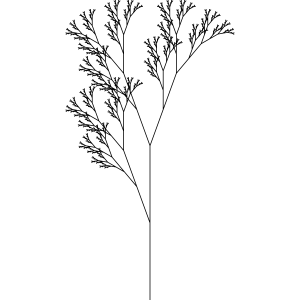

In [11]:
prods = (
    ('X', 'F[+X]F[-X]+X'),
    ('F', 'FF'),
)
render_svg(interp(apply_prods('X', prods, n=7), delta=20), width=300, height=300)

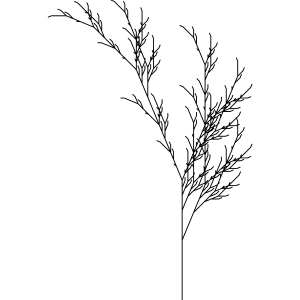

In [57]:
prods = (
    ('X', 'F-[[X]+X]+F[+FX]-X'),
    ('F', 'FF'),
)
render_svg(interp(apply_prods('X', prods, n=5), delta=22.5), width=300, height=300)

# Context-Sensitive

In [14]:
lines = '''0 < 0 > 0 → 1
0 < 0 > 1 → 1[-F1F1]
0 < 1 > 0 → 1
0 < 1 > 1 → 1
1 < 0 > 0 → 0
1 < 0 > 1 → 1F1
1 < 1 > 0 → 1
1 < 1 > 1 → 0
* < + > * → -
* < - > * → +'''
prods = [l.split()[::2] for l in lines.split('\n')]
assert prods[0]=='0,0,0,1'.split(',')

def gen_context_sensitive_prods(string, prods, ignore=('-', '+', 'F')):
    # First, parse the string into left/right contexts
    parent_idx = None
    stack = []
    context = [None]*len(string)
    for chidx, ch in enumerate(string):
        if ch == '[':
            stack.append(parent_idx)
        elif ch == ']':
            parent_idx = stack.pop()
        else:
            if parent_idx is None:
                context[chidx] = (None, [])
            else:
                context[chidx] = (string[parent_idx], [])
                # Non-ignored characters are added as context.
                if ch not in ignore:
                    context[parent_idx][-1].append(ch)
            # For non-ignored characters, we set the new parent.
            if ch not in ignore:
                parent_idx = chidx

    # Second, use parsed representation to evaluate production rules.
    for chidx, ch in enumerate(string):
        if context[chidx]:
            lcontext, rcontexts = context[chidx]
            for left, start, right, result in prods:
                if (
                    (left == '*' or left == lcontext) and
                    start == ch and
                    (right == '*' or right in rcontexts)
                    #(right == '*' or (rcontexts and right == rcontexts[0]))
                ):
                    yield from result
                    break
            else:
                yield ch
        else:
            yield ch

assert ''.join(gen_context_sensitive_prods('1[0]1[+0]1', prods)) == '1[0]1[-0]1'
assert ''.join(gen_context_sensitive_prods('1[0]1[+1]0', prods)) == '1[0]1[-1]0'
#assert ''.join(gen_context_sensitive_prods('11[+1]0', prods)) == '10[-1]0'

Doesn't look like the text...

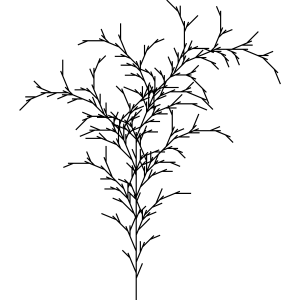

In [13]:
def apply_context_sensitive_prods(string, prods, n=1):
    for _ in range(n):
        string = list(gen_context_sensitive_prods(string, prods))
    return string

render_svg(
    interp(apply_context_sensitive_prods('F1F1F1', prods, n=30), delta=22.5),
    width=300, height=300)

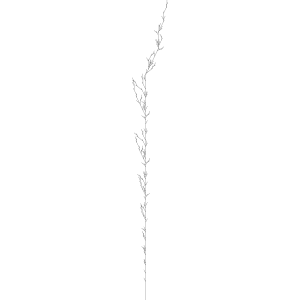

In [14]:
lines='''0 < 0 > 0 → 1
0 < 0 > 1 → 0
0 < 1 > 0 → 0
0 < 1 > 1 → 1F1
1 < 0 > 0 → 1
1 < 0 > 1 → 1[+F1F1]
1 < 1 > 0 → 1
1 < 1 > 1 → 0
* < + > * → -
* < - > * → +'''
prods = [l.split()[::2] for l in lines.split('\n')]

render_svg(
    interp(apply_context_sensitive_prods('F0F1F1', prods, n=24), delta=25.75),
    width=300, height=300)